## Learning
Draft training script, and draft results production pipline.

1. [done] Deterministic write pipeline for producing df w [mean, std, actual]
2. [done] Train ensemble
#### remaining steps in `STimage_Bayes_reggression_prediction.ipynb`
3. Bayesian write pipeline for producing df w [epistemic, aleatoric, total_uncertainty, expectation, variance, actual]
4. Produce plot showing the selective prediction w uncertainty thresholding
5. Produce plot showing histology slide with companion aleatoric, epistemic, and total

In [49]:
from pathlib import Path
from anndata import read_h5ad
import sys
import scanpy

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.stats import nbinom, pearsonr, spearmanr

from tensorflow.keras.models import load_model

In [15]:
import tensorflow as tf
from tensorflow.keras import backend as K

# stimage custom 
file = Path("../stimage").resolve() # path to src code
parent = file.parent
sys.path.append(str(parent))

from stimage._utils import gene_plot, Read10X, ReadOldST, tiling
from stimage._model import CNN_NB_multiple_genes, negative_binomial_layer, negative_binomial_loss
from stimage._data_generator import DataGenerator

In [3]:
DATA_PATH = Path("/scratch/smp/uqsmac12/dataset_breast_cancer_9visium")

OUT_PATH = Path("/scratch/smp/uqsmac12/results")
OUT_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
(DATA_PATH / "all_adata.h5ad").exists()

True

In [5]:
adata_all = read_h5ad(DATA_PATH / "all_adata.h5ad")

The annadata object `adata_all` contains STexpression readings for each spot (represented in a spotXexpression matrix). The bellow script accesses cell attribute information and updates the path.

In [6]:
# update metadata for annadata such that it maps to the correct location
adata_all.obs["tile_path"] = adata_all.obs.tile_path.map(
    lambda x: x.replace("/clusterdata/uqxtan9/Xiao/breast_cancer_9visium",
                        "/scratch/smp/uqsmac12/dataset_breast_cancer_9visium"))

In [7]:
adata_all.obs["tile_path"][0]

'/scratch/smp/uqsmac12/dataset_breast_cancer_9visium/tiles/1142243F-12601-4511-299.jpeg'

In [8]:
gene_list=["COX6C","TTLL12", "PABPC1", "GNAS", "HSP90AB1", 
           "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]
gene_list

['COX6C',
 'TTLL12',
 'PABPC1',
 'GNAS',
 'HSP90AB1',
 'TFF3',
 'ATP1A1',
 'B2M',
 'FASN',
 'SPARC',
 'CD74',
 'CD63',
 'CD24',
 'CD81']

In [9]:
# remove FFPE and 1160920F --- the test set
adata_all_train_valid = adata_all[adata_all.obs["library_id"].isin(
    adata_all.obs.library_id.cat.remove_categories(["FFPE", "1160920F"]).unique())]

In [10]:
n_genes = len(gene_list)

training_index = adata_all_train_valid.obs.sample(frac=0.7, random_state=1).index
training_dataset = adata_all_train_valid[training_index,].copy()

valid_index = adata_all_train_valid.obs.index.isin(training_index)
valid_dataset = adata_all_train_valid[~valid_index,].copy()

test_index = adata_all.obs.library_id == "FFPE"
test_dataset_1 = adata_all[test_index,].copy()

test_index = adata_all.obs.library_id == "1160920F"
test_dataset_2 = adata_all[test_index,].copy()

In [11]:
train_gen = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=training_dataset, 
                          genes=gene_list, aug=False),
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
train_gen_ = train_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
valid_gen = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=valid_dataset, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
valid_gen_ = valid_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_gen_1 = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_dataset_1, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__1 = test_gen_1.batch(1)
test_gen_2 = tf.data.Dataset.from_generator(
            lambda: DataGenerator(adata=test_dataset_2, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__2 = test_gen_2.batch(1)

In [22]:
# instantiate model
K.clear_session()
model = CNN_NB_multiple_genes((299, 299, 3), n_genes, cnnbase="resnet50")
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10,
    restore_best_weights=True
)

# change the learning rate to improve results
lr_ = 1e-4
model.optimizer.learning_rate.assign(lr_)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-04>

In [ ]:
with tf.device("GPU:0"):
    train_history = model.fit(train_gen_,
                              epochs=100,
                              validation_data=valid_gen_,
                              callbacks=[callback]
                              )

Epoch 1/100
     31/Unknown - 144s 3s/step - loss: 39.8361 - gene_0_loss: 2.8108 - gene_1_loss: 1.0928 - gene_2_loss: 3.9588 - gene_3_loss: 3.2755 - gene_4_loss: 3.4985 - gene_5_loss: 2.0125 - gene_6_loss: 1.6344 - gene_7_loss: 4.2643 - gene_8_loss: 1.7430 - gene_9_loss: 2.5387 - gene_10_loss: 4.5705 - gene_11_loss: 2.8768 - gene_12_loss: 3.6553 - gene_13_loss: 1.9043

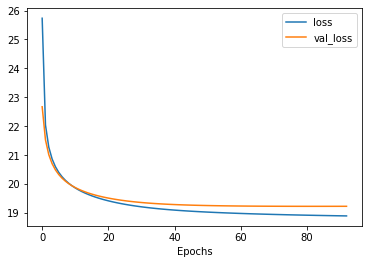

In [25]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

In [26]:
model.save(OUT_PATH / f"resnet50_single-rev3.h5")

In [45]:
# TO DO

# 1. deterministic write pipeline for producing df w [mean, std, actual]
# 1.5. train ensemble
# 2. Bayesian write pipeline for producing df w [epistemic, aleatoric, total_uncertainty, expectation, variance, actual]
# 3. produce plot showing the selective prediction w uncertainty thresholding
# 4. produce plot showing histology slide with companion aleatoric, epistemic, and total

# 
# Draft results by end of week 2 (Feb-17th)

(2338, 14)

In [16]:
# load trained model
model = None
file_model = str(OUT_PATH / f"resnet50_single-rev3.h5")
model = load_model(
    file_model, 
    custom_objects={
        'negative_binomial_loss': negative_binomial_loss,
    }
)

In [17]:
pred_test_1 = model.predict(test_gen__1)

In [18]:
pred_test_2 = model.predict(test_gen__2)

In [20]:
df_target_1 = test_dataset_1.to_df().loc[:, gene_list]

In [21]:
df_target_2 = test_dataset_2.to_df().loc[:, gene_list]

In [71]:
def get_results(df_target, np_preds, list_genes):
    
    # instantiate dictionary
    list_results = []
    
    for gene_idx, gene_name in enumerate(list_genes):
        
        # actual 
        target = df_target[gene_name]

        # predicted NB params 
        n, p = np_preds[gene_idx][:,0], np_preds[gene_idx][:,1]
        
        # mean, var, std 
#         # mean and var functions of k...
#         nb_mean = lambda n, p, k: n*(1-p*k)/(p*k)
#         nb_var = lambda n, p, k: n*(1-p*k)/(p*p*k*k)
        mu, var = nbinom.stats(n, p, moments='mv')
        std = np.sqrt(var)

        # create dataframe
        df_temp = pd.DataFrame(
            data=np.stack([n, p, mu, var, std, target], axis=1), 
            columns=['n', 'p', 'mean', 'var', 'std', 'target'],
            index= df_target.index
        )
        
        df_temp['gene_name']=gene_name
        
        # append dictionary
        list_results.append(df_temp)
        
    return pd.concat(list_results, axis=0)

In [72]:
df_target = df_target_1.copy()
np_preds = pred_test_1.copy()
list_genes = gene_list.copy()

In [75]:
df_res1 = get_results(
    df_target = df_target_1, 
    np_preds = pred_test_1,
    list_genes = gene_list
)

In [76]:
df_res2 = get_results(
    df_target = df_target_2, 
    np_preds = pred_test_2,
    list_genes = gene_list
)

In [83]:
df_res1.to_csv(str(OUT_PATH / 'df_model_stats-ffpe-rev3.csv'))
df_res2.to_csv(str(OUT_PATH/ 'df_model_stats-1160920F-rev3.csv'))

In [88]:
df_res1.head()

,n,p,mean,var,std,target,gene_name
AAACAAGTATCTCCCA-1-FFPE,206.790833,0.986477,2.834860,2.873723,1.695206,2.944439,COX6C
AAACACCAATAACTGC-1-FFPE,157.495789,0.976582,3.776677,3.867240,1.966530,1.098612,COX6C
AAACAGAGCGACTCCT-1-FFPE,195.672424,0.984948,2.990366,3.036067,1.742431,2.079442,COX6C
AAACAGCTTTCAGAAG-1-FFPE,154.036575,0.967745,5.134034,5.305151,2.303291,1.098612,COX6C
AAACAGGGTCTATATT-1-FFPE,172.619781,0.980994,3.344441,3.409238,1.846412,0.693147,COX6C


In [84]:
df_corr1 = df_res1.groupby('gene_name').apply(lambda x: pearsonr(x['mean'], x['target'])[0])
df_corr2 = df_res2.groupby('gene_name').apply(lambda x: pearsonr(x['mean'], x['target'])[0])

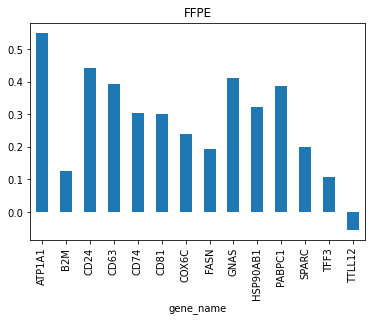

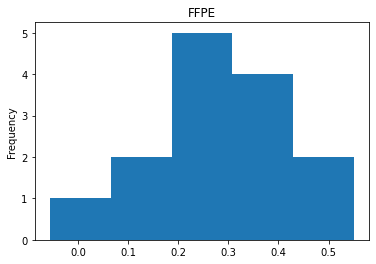

In [85]:
df_corr1.plot.bar()
plt.title('FFPE')
plt.show()
df_corr1.plot.hist(bins=5)
plt.title('FFPE')
plt.show()

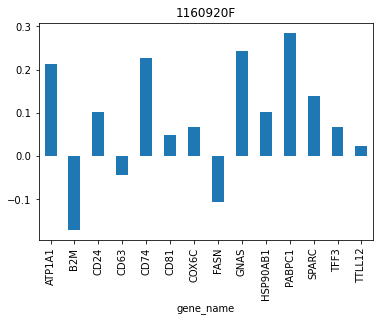

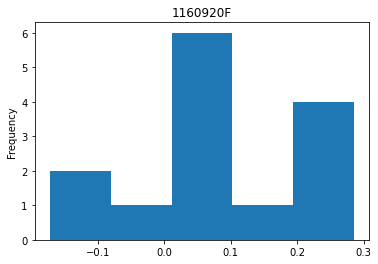

In [87]:
df_corr2.plot.bar()
plt.title('1160920F')
plt.show()
df_corr2.plot.hist(bins=5)
plt.title('1160920F')
plt.show()